# Use example of TiT

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import torch
import torch.nn as nn
import json
from collections import namedtuple
from utils import *
from sampler import sampler_longseq, get_srdec_func, sampler_mix_dps, sample_ar
from torch_ema import ExponentialMovingAverage
import matplotlib.pyplot as plt
from modules_irsde import get_conditional_unet, get_palsb_unet
from opensora import get_conditional_dit
from einops import rearrange
from svd_operator import Inpainting2

data_name = 'kol'           # kol, buoyancy, buoyancy_joint
version = 'down_dit'      # 'down_dit_re1', 'down_dit_cond', 'down_dit_ca', 'down_dit_ssl', 'down_dit_ssl_tempshift', 'down_dit_framecond', 'unet3d', 'dit_dynamic'
opt_path = './__results__/' + data_name + '_' + version + '/opt.json'
with open(opt_path, 'r', encoding='utf-8') as f:
    opt = json.load(f)
OPT_class = namedtuple('OPT_class', opt.keys())
opt = OPT_class(**opt)

data_name_dec = 'kol'
version_dec = 'dit_e2edec_v1'      # 'v7_seq', 'v8_fullfield', 'v3_noise', 'v9_nearest'
base_path_for_dec = '/media/group3/lzy/SGM/__results__/'
opt_path_dec = base_path_for_dec + data_name_dec + '_' + version_dec + '/opt.json'
with open(opt_path_dec, 'r', encoding='utf-8') as f:
    opt_dec = json.load(f)
    opt_dec['results_path'] = base_path_for_dec + data_name_dec + '_' + version_dec
OPT_class_dec = namedtuple('OPT_class', opt_dec.keys())
opt_dec = OPT_class_dec(**opt_dec)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/lzy/anaconda3/envs/opensora/lib/python3.9/site-packages/colossalai/pipeline/schedule/_utils.py:19: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _register_pytree_node(OrderedDict, _odict_flatten, _odict_unflatten)
/home/lzy/anaconda3/envs/opensora/lib/python3.9/site-packages/torch/utils/_pytree.py:254: UserWarning: <class 'collections.OrderedDict'> is already registered as pytree node. Overwriting the previous registration.
  warnings.warn(
/home/lzy/anaconda3/envs/opensora/lib/python3.9/site-packages/colossalai/shardformer/layer/normalization.py:45: UserWarning: Please install apex from source (https://github.com/NVIDIA/apex) to use the fused layernorm kernel
  warnings.warn("Please install apex from source (https://github.com/NVIDIA/apex) to use the fused layernorm kernel")


# load DiT

In [10]:
if hasattr(opt, 'patch_size'):
    net = get_conditional_dit(opt)
else:
    net = get_conditional_unet(opt)
ema = ExponentialMovingAverage(net.parameters(), decay=opt.ema_rate)
dtype = torch.float32
print(sum(p.numel() for p in net.parameters() if p.requires_grad))

ckpt_path = opt.results_path + '/checkpoint_40000.pt'
ckpt = torch.load(ckpt_path)
net.load_state_dict(ckpt['net'])
net = nn.DataParallel(net)
net.to(device).eval()       # .to(dtype)
try:
    ema.load_state_dict(ckpt["ema"])
    ema.to(device)
    print(f"[Ema] Loaded ema ckpt!")
except:
    ema = None
    print('No ema found!')
try:
    mean, std = np.load(opt.results_path + '/mean_std.npy')
    scalar = lambda x: (x-mean)/std
    scalar_inv = lambda x: x*std+mean
    print(f"[Scalar] Loaded scalar!")
except:
    scalar = lambda x: x
    scalar_inv = lambda x: x
    print('No scalar found!')

16555780
[Ema] Loaded ema ckpt!
[Scalar] Loaded scalar!


# load decoder model

In [3]:
net_dec = get_palsb_unet(opt_dec)
ema_dec = ExponentialMovingAverage(net_dec.parameters(), decay=opt_dec.ema_rate)
dtype = torch.float32
print(sum(p.numel() for p in net_dec.parameters() if p.requires_grad))

ckpt_path_dec = opt_dec.results_path + '/checkpoint_tunePFF.pt'
ckpt_dec = torch.load(ckpt_path_dec)
net_dec.load_state_dict(ckpt_dec['net'])
net_dec = nn.DataParallel(net_dec)
net_dec.to(device).eval()       # .to(dtype)
try:
    ema_dec.load_state_dict(ckpt_dec["ema"])
    ema_dec.to(device)
    print(f"[Ema] Loaded ema_dec ckpt!")
except:
    ema_dec = None
    print('No ema_dec found!')
try:
    mean_dec, std_dec = np.load(opt_dec.results_path + '/mean_std.npy')
    scalar_dec = lambda x: (x-mean_dec)/std_dec
    scalar_inv_dec = lambda x: x*std_dec+mean_dec
    print(f"[Scalar] Loaded scalar!")
except:
    scalar_dec = lambda x: x
    scalar_inv_dec = lambda x: x
    print('No scalar found!')

34818608
[Ema] Loaded ema_dec ckpt!
[Scalar] Loaded scalar!


# Load test data

In [4]:
from einops import rearrange
import h5py
from pathlib import Path
coarse_dim = 32
down_sampler = torch.nn.Upsample(size=coarse_dim, mode='bilinear')

t_start = 0
cond = 1000
data_test = np.load("data/kf_2d_re1000_256_40seed_valid.npy")     # load test data
sample = data_test[[0], t_start:, np.newaxis]
sample_coarse = down_sampler(torch.from_numpy(sample[0]))[None].numpy()

print(sample.shape, sample_coarse.shape)

(1, 320, 1, 256, 256) (1, 320, 1, 32, 32)


# Configurations for generation

In [5]:
# generation configurations
N = 50
sigma_min, sigma_max, rho = 0.02, 1, 7
gamma=0.8
m = 2                   # overlap between samples
T_prime = 100           # target number of frames to generate
coeff = 0.5             # guidance weight for observation consistency (\gamma in the paper)
coeff_consis = 0.01     # guidance weight for sequence consistency
w_cfg = -1              # not used
jacob = 'dps'           # DO NOT CHANGE!
consis_xt = False       # useless

# observation type and scales
degen_type = 'ri'  # observation type: forecast, ri, fi
scale = 0.999       # scale for getting the observations, which means sparsity for 'ri' type observation, down-sampling factor for 'fi' type observation. This value is not used for 'forecast'
noise_level = 0.    # observation noise

# Generation!

In [11]:
# sampling
setup_seed(42)

net.eval()
num_frame_cond = 0
stt_frame_pred = 0
if hasattr(opt, 'frame_cond_strategy') and 'cross_attn' in opt.frame_cond_strategy:
    num_frame_cond = int(opt.frame_cond_strategy.split('_')[-1])
    if '_ol_' not in opt.frame_cond_strategy:
        stt_frame_pred = num_frame_cond

shape = [1, opt.in_channels, opt.input_size[0], opt.input_size[1], opt.input_size[2]]
if hasattr(opt, 'condition') and opt.condition.startswith('label'):
    label = torch.zeros(shape[0]).long()  
else:
    label = (cond/100*torch.ones([shape[0], 1])).log().to(dtype) if 'kol' in opt.data.lower() else cond*torch.ones([shape[0], 1]).to(dtype)

nf = opt.num_frames
b = int(np.ceil((T_prime-m)/(nf-m)))      # the number of samples that need to generate
ns_real = b*(nf-m)+m       # exact number of steps generated
shape_dec = [1, opt.in_channels, ns_real, opt_dec.scale*opt.input_size[1], opt_dec.scale*opt.input_size[2]]

if 'forecast' in degen_type:
    # for forecasting
    mask = torch.zeros(shape)
    mask[:, :2, :2] = 1
    A_func = Inpainting2(opt.num_frames, opt.input_size[0], mask, device=device)
    A_func.set_indices(torch.tensor([0]))
    y = rearrange(torch.from_numpy(scalar(sample_coarse)).float(), 'b t c h w -> b c t h w')[:, :, stt_frame_pred:opt.num_frames]*mask
else:
    if 'ri' in degen_type:
        # for random reconstruction
        mask = mask_gen(shape_dec, mask_ratio=scale)
        mask = torch.from_numpy(mask)
    elif 'fi' in degen_type:
        # for regular reconstruction
        mask = torch.zeros(shape_dec)
        mask[..., ::scale, ::scale] = 1
    A_func = Inpainting2(opt.num_frames, opt.input_size[0], mask, device=device)
    A_func.set_indices(torch.tensor([0]))
    y = rearrange(torch.from_numpy(scalar(sample)).float(), 'b t c h w -> b c t h w')[:, :, stt_frame_pred:ns_real]
    y = (y + torch.randn_like(y)*noise_level*y.std())*mask

frame_cond = rearrange(torch.from_numpy(scalar(sample_coarse)).float(), 'b t c h w -> b c t h w')[:, :, :num_frame_cond]

steps = (sigma_max**(1./rho)+np.arange(N)/(N-1)*(sigma_min**(1./rho)-sigma_max**(1./rho)))**rho

if 'forecast' in degen_type:
    dec_kwargs = dict(
        bound_type='periodic', num_bound_padding=2, nfe=10, scalars=(scalar, scalar_inv, scalar_dec, scalar_inv_dec)
    )
    dec_func = get_srdec_func(net_dec, ema_dec, opt_dec, model_type='diffusion' if 'diffusion' in opt_dec.model_name else 'e2e', **dec_kwargs)
    sampler_dict = dict(
        net=net, ema=ema, steps=steps, shape=shape, y=y.to(device), device=device, eps=1e-8, verbose=False, w_cfg=w_cfg, gamma=gamma, label=label.to(device), dtype=dtype, coeff=coeff, coeff_ar=coeff, H=A_func, dec=dec_func,
    )
    x_pred_enc, x_pred = sample_ar(sampler_mix_dps, T_prime=T_prime, T=opt.num_frames, m=m, **sampler_dict)     # sampler_mix_dps
    x_pred = scalar_inv_dec(x_pred)
    x_pred_enc = scalar_inv(x_pred_enc)
    y = scalar_inv(y)
else:
    dec_kwargs = dict(
        bound_type='periodic', num_bound_padding=2, nfe=10, scalars=(scalar, scalar_inv, scalar_dec, scalar_inv_dec)
    )
    dec_func = get_srdec_func(net_dec, ema_dec, opt_dec, model_type='diffusion' if 'diffusion' in opt_dec.model_name else 'e2e', **dec_kwargs)
    enc_func = lambda x: rearrange(down_sampler(x.flatten(0, 1)), '(b c) t h w -> b c t h w', b=len(x))
    sampler_dict = dict(
        net=net, ema=ema, steps=steps, gamma=gamma, shape=shape, y=y.to(device), device=device, eps=1e-8, verbose=False, w_cfg=w_cfg, label=label.to(device), dtype=dtype, coeff=coeff, coeff_consis=coeff_consis, H=A_func,
        T_prime=T_prime, overlap=m, enc=enc_func, dec=dec_func, jacob=jacob, consis_xt=consis_xt,
    )
    optim_para = dict(
        optimizer='Adam', lr=1e-2, betas=(0.9, 0.999),
    )
    x_pred_enc, x_pred, loss_rec = sampler_longseq(**sampler_dict, **optim_para)
    x_pred_enc = scalar_inv(x_pred_enc).detach().cpu()
    x_pred = scalar_inv_dec(x_pred).detach().cpu()
    y = scalar_inv(y)

torch.cuda.empty_cache()

# Visualization of results

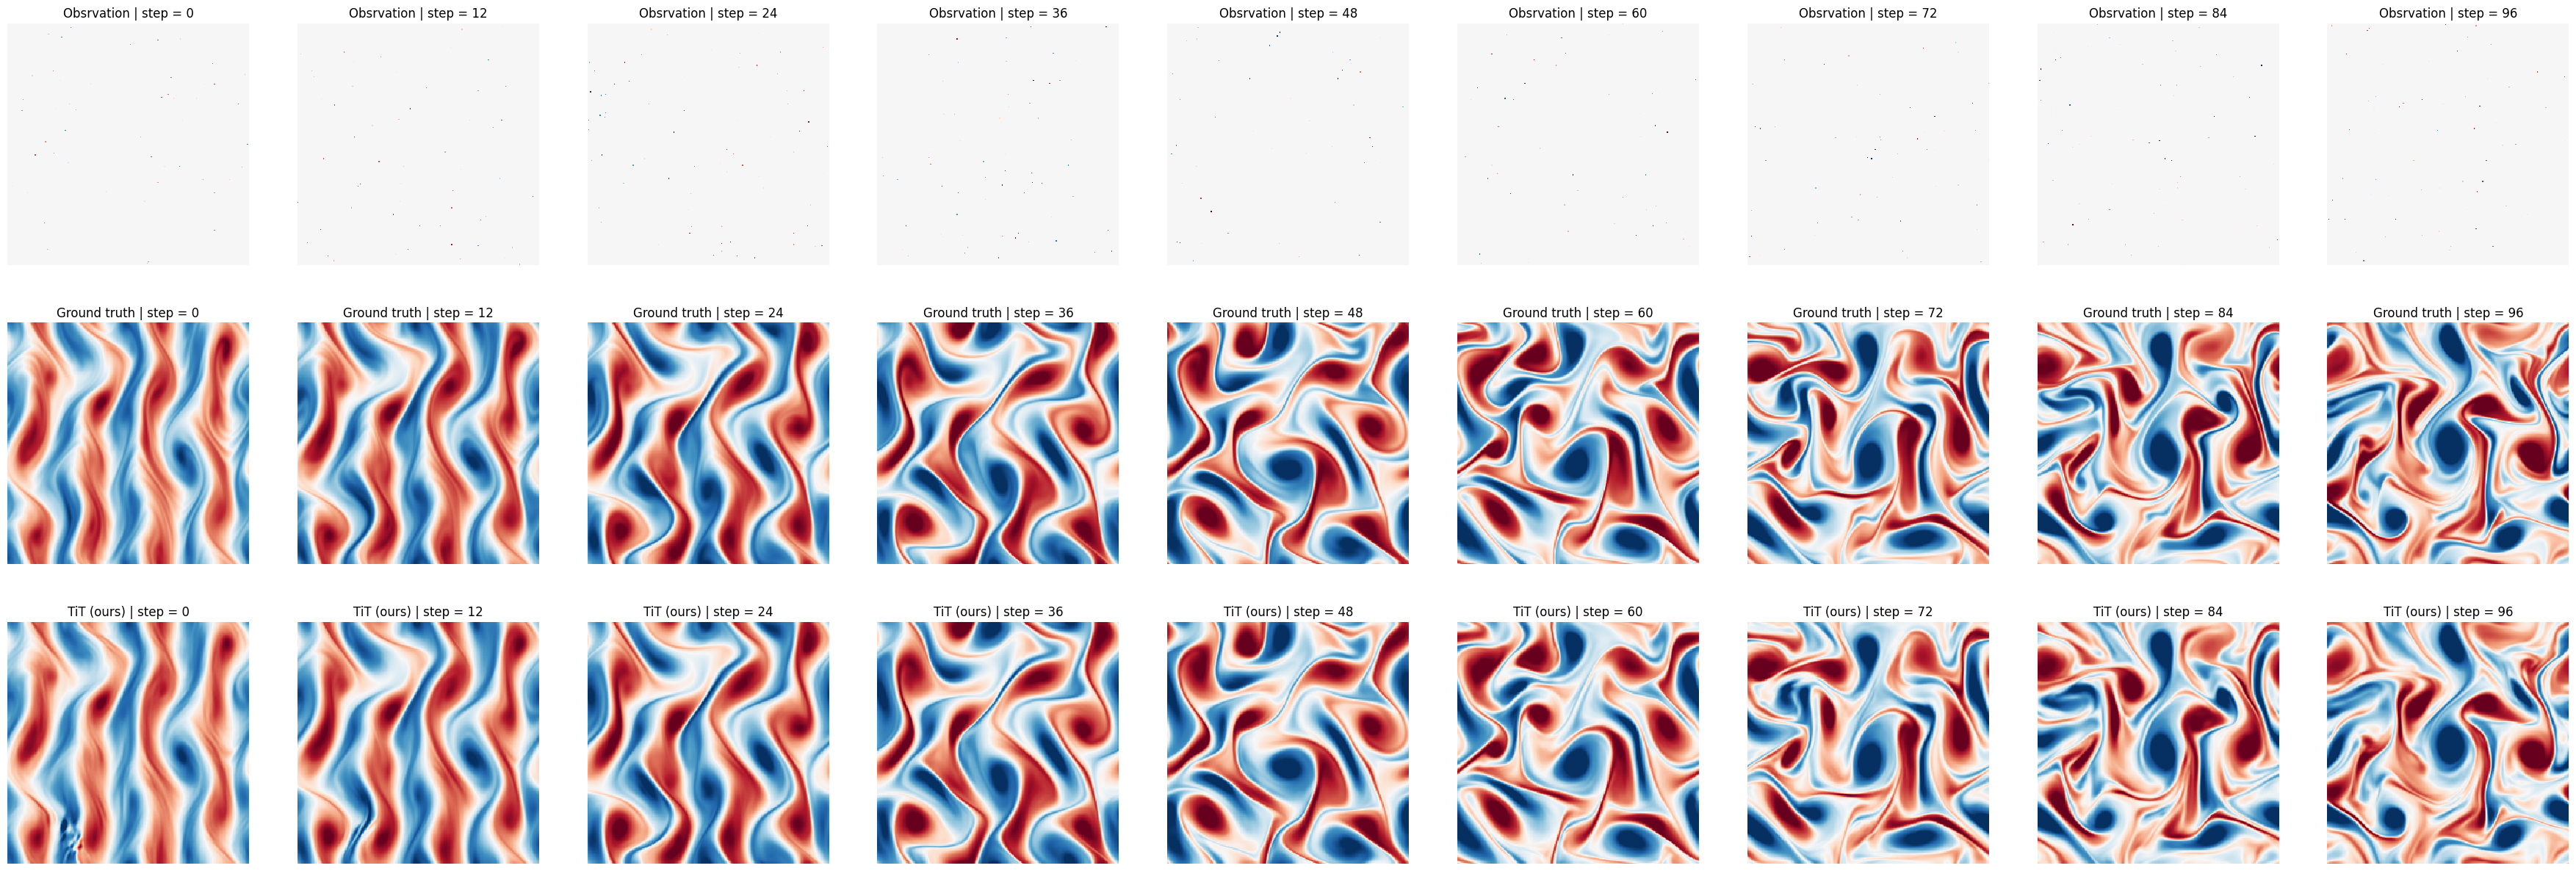

In [12]:
ib, ic = 0, 0
t_stt, t_sp, t_end = 0, 12, 100
x_plots = [y[ib, ic, t_stt:t_end:t_sp], sample[ib, t_stt:t_end:t_sp, ic], x_pred[ib, ic, t_stt:t_end:t_sp]]
titles = ['Obsrvation', 'Ground truth', 'TiT (ours)']
height, width = len(x_plots), len(x_plots[0])
plt.figure(figsize=(width*5, height*5))
for i in range(height):
    for j in range(width):
        plt.subplot(height, width, i*width+j+1)
        plt.pcolormesh(x_plots[i][j], cmap='RdBu_r', vmin=-10, vmax=10)
        plt.title(titles[i] + f' | step = {t_stt+t_sp*j}')
        plt.gca().axis('off')
        plt.gca().set_aspect(1)
# plt.savefig('__results__/figs/method_latent_variable_gen.pdf')
plt.show()

# Quantitative results

##################################################################
############ Averaged relative error (nRMSE): 0.1715 #############
##################################################################


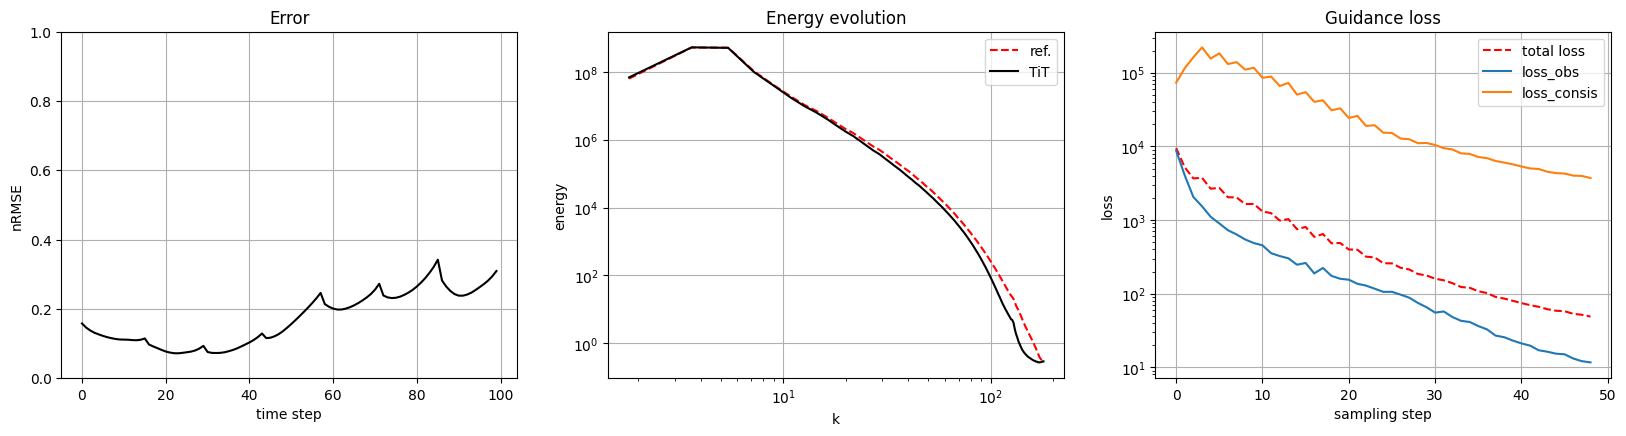

In [13]:
T_error = 100
error = cal_rmse(sample[ib, :T_error], rearrange(x_pred[ib, :, :T_error].numpy(), 'c t h w -> t c h w'), normalize=True)
error_coarse = cal_rmse(sample_coarse[ib, :T_error], rearrange(x_pred_enc[ib, :, :T_error].numpy(), 'c t h w -> t c h w'), normalize=True)
# energy = (x_pred[ib, 0, :T_error]**2+x_pred[ib, 1, :T_error]**2).mean(-1).mean(-1)
# energy_ref = (sample_coarse[ib, :T_error, 0]**2+sample_coarse[ib, :T_error, 1]**2).mean(-1).mean(-1)
energy = (x_pred[ib, 0, :T_error]**2).mean(-1).mean(-1)
energy_ref = (sample_coarse[ib, :T_error, 0]**2).mean(-1).mean(-1)

dx = dy = 2*np.pi/256
num_bins = 100
k, Es, _ = kes_plot([sample[ib, t_stt:t_end, ic], x_pred[ib, ic, t_stt:t_end]], dx, dy, start=t_stt, end=t_end, num_bins=num_bins, )

print("##################################################################")
print(f"############ Averaged relative error (nRMSE): {error.mean():.4f} #############")
print("##################################################################")

plt.figure(figsize=(20, 4.5))
plt.subplot(131)
plt.plot(error[:], c='black')
plt.xlabel('time step')
plt.ylabel('nRMSE')
plt.ylim(-0., 1)
plt.grid('on')
plt.title('Error')
plt.subplot(132)
for i in range(len(Es)):
    if i==0:
        plt.plot(k, Es[i], ls='--', c='r', label='ref.')
    else:
        plt.plot(k, Es[i], c='black', label=f'TiT')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('energy')
plt.title('Energy evolution')
plt.grid('on')
plt.legend()
plt.subplot(133)
if 'forecast' in degen_type:
    plt.plot(np.ones(10))
else:
    for k in loss_rec.keys():
        if k == 'loss':
            plt.plot(loss_rec[k], label='total loss', ls='--', c='r')
        else:
            plt.plot(loss_rec[k], label=k)
# plt.plot(error_coarse_[:], label='w/o. SSL')
plt.xlabel('sampling step')
plt.ylabel('loss')
plt.title('Guidance loss')
plt.yscale('log')
plt.grid('on')
plt.legend()
plt.show()